In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

def graph_mtree(name_file):
    cmap = plt.cm.viridis

    # Function to parse the custom data format
    def parse_data(row):
        p_match = re.search(r'p:\(([^)]+)\)', row)
        h_match = re.search(r'h:(\d+)', row)
        n_match = re.search(r'n:(\d+)', row)
        cr_match = re.search(r'cr:(\d+.\d+)', row)
        if (not cr_match):
            cr_match = re.search(r'cr:(\d+)', row)

        if not (p_match and h_match and cr_match and n_match):
            return None  # Return None if any patterns do not match
        
        p = tuple(map(float, p_match.group(1).split(',')))
        h = int(h_match.group(1))
        cr = float(cr_match.group(1))
        n = int(n_match.group(1))
        return p, h, cr, n

    # Read the CSV file
    df = pd.read_csv(name_file, header=None, delimiter=";")

    # Prepare the plot
    fig, ax = plt.subplots(figsize=(14, 14))

    # Find min and max h values for normalization
    min_h = df[0].apply(lambda x: int(re.search(r'h:(\d+)', x).group(1))).min()
    max_h = df[0].apply(lambda x: int(re.search(r'h:(\d+)', x).group(1))).max()
    norm = mcolors.Normalize(vmin=min_h, vmax=max_h)

    # Process each row in the DataFrame
    for index, row in df.iterrows():
        result = parse_data(row[0])
        if result:
            p, h, cr, n = result

            if n == 0:
                markersize = 1
                ax.plot(p[0], p[1], 'bo', markersize=markersize)
            else:
                color = cmap(norm(h))
                circle = plt.Circle(p, cr, color=color, fill=False)  # Draw a red circle for n!=0
                ax.add_artist(circle)

    # Set equal scaling by setting the aspect ratio to 'equal'
    ax.set_aspect('equal', adjustable='datalim')
    plt.grid(True)
    plt.show()


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm

def read_data(file_path):
    """Reads a CSV file directly into a DataFrame with correct types."""
    # Using a more direct approach to parsing the CSV
    data = pd.read_csv(file_path, delimiter=';', header=None)
    data = data[0].str.extract(r'size:(?P<size>\d+),ios:(?P<ios>\d+)')
    data['size'] = pd.to_numeric(data['size'])
    data['ios'] = pd.to_numeric(data['ios'])
    return data

def calculate_confidence_interval(data, confidence=0.95):
    """Calculates the confidence interval for a given dataset of ios values."""
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    z_score = norm.ppf((1 + confidence) / 2)  # Get z-score from the normal distribution
    margin_error = z_score * (std_dev / np.sqrt(n))
    return mean, mean - margin_error, mean + margin_error

def analyze_file(file_path):
    data = read_data(file_path)
    ios_mean, ios_lower_bound, ios_upper_bound = calculate_confidence_interval(data['ios'])
    size_mean = np.mean(data['size'])
    return {
        'IOS Mean': ios_mean,
        'IOS 95% CI Lower': ios_lower_bound,
        'IOS 95% CI Upper': ios_upper_bound,
        'Size Mean': size_mean
    }

for size in [x+10 for x in range(6)]:
    file_path = f'cp/search_{size}.csv'
    results = analyze_file(file_path)
    print(f"IOS Mean: {results['IOS Mean']:<6}, IOS 95% CI: ({results['IOS 95% CI Lower']:<18}, {results['IOS 95% CI Upper']:<18}), Size Mean: {results['Size Mean']:<5}")


IOS Mean: 160.64, IOS 95% CI: (148.50734879365794, 172.77265120634203), Size Mean: 1.16 
IOS Mean: 217.97, IOS 95% CI: (207.82334766006338, 228.11665233993662), Size Mean: 2.37 
IOS Mean: 294.51, IOS 95% CI: (279.14123680423086, 309.8787631957691 ), Size Mean: 5.1  
IOS Mean: 344.83, IOS 95% CI: (327.6531250361443 , 362.0068749638557 ), Size Mean: 9.97 
IOS Mean: 388.81, IOS 95% CI: (371.483963727599  , 406.136036272401  ), Size Mean: 19.79
IOS Mean: 473.49, IOS 95% CI: (455.41748058308553, 491.5625194169145 ), Size Mean: 40.34


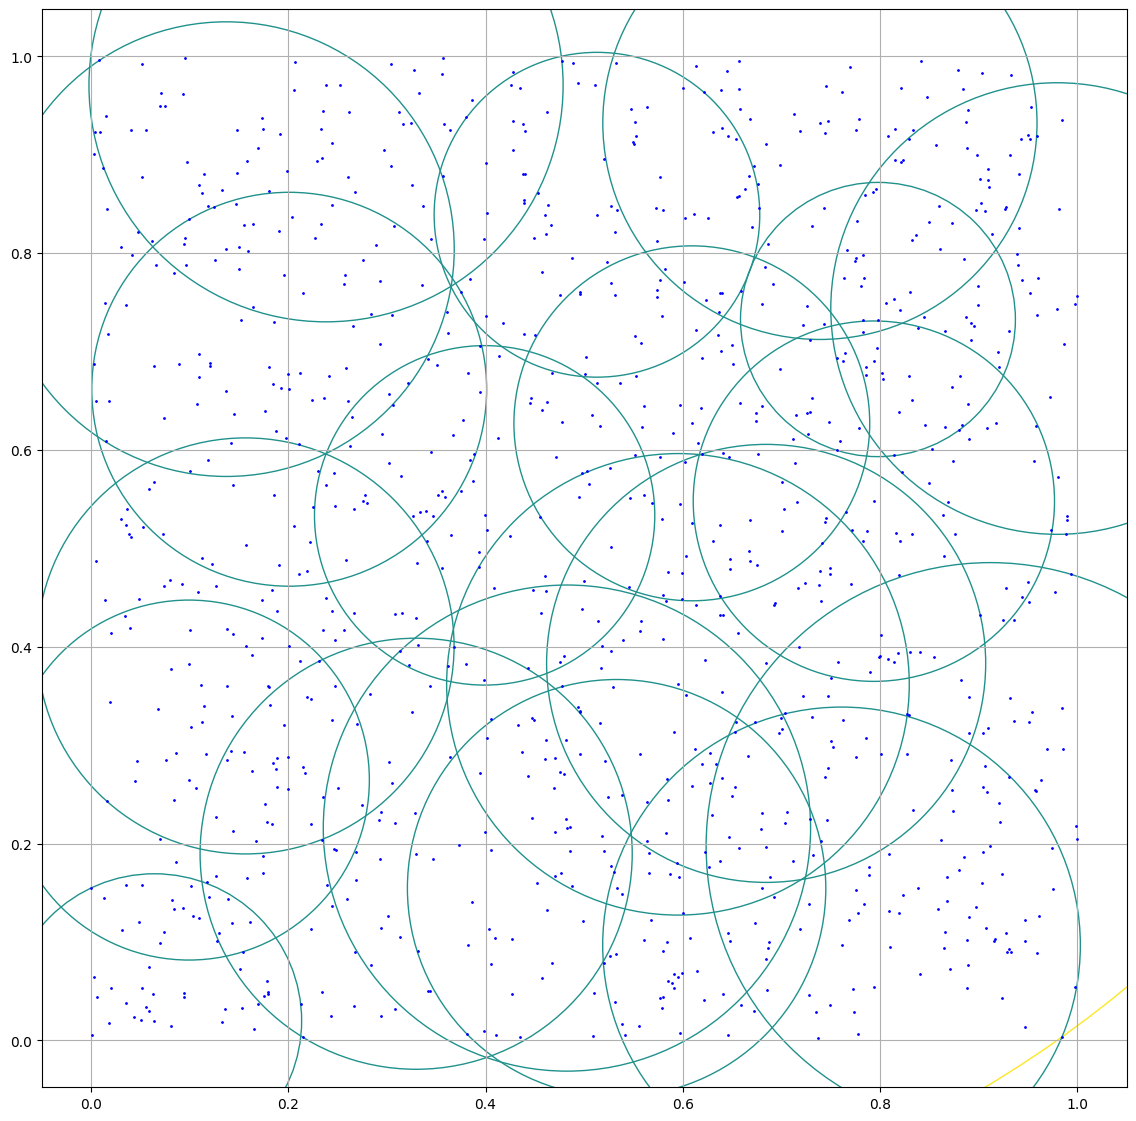

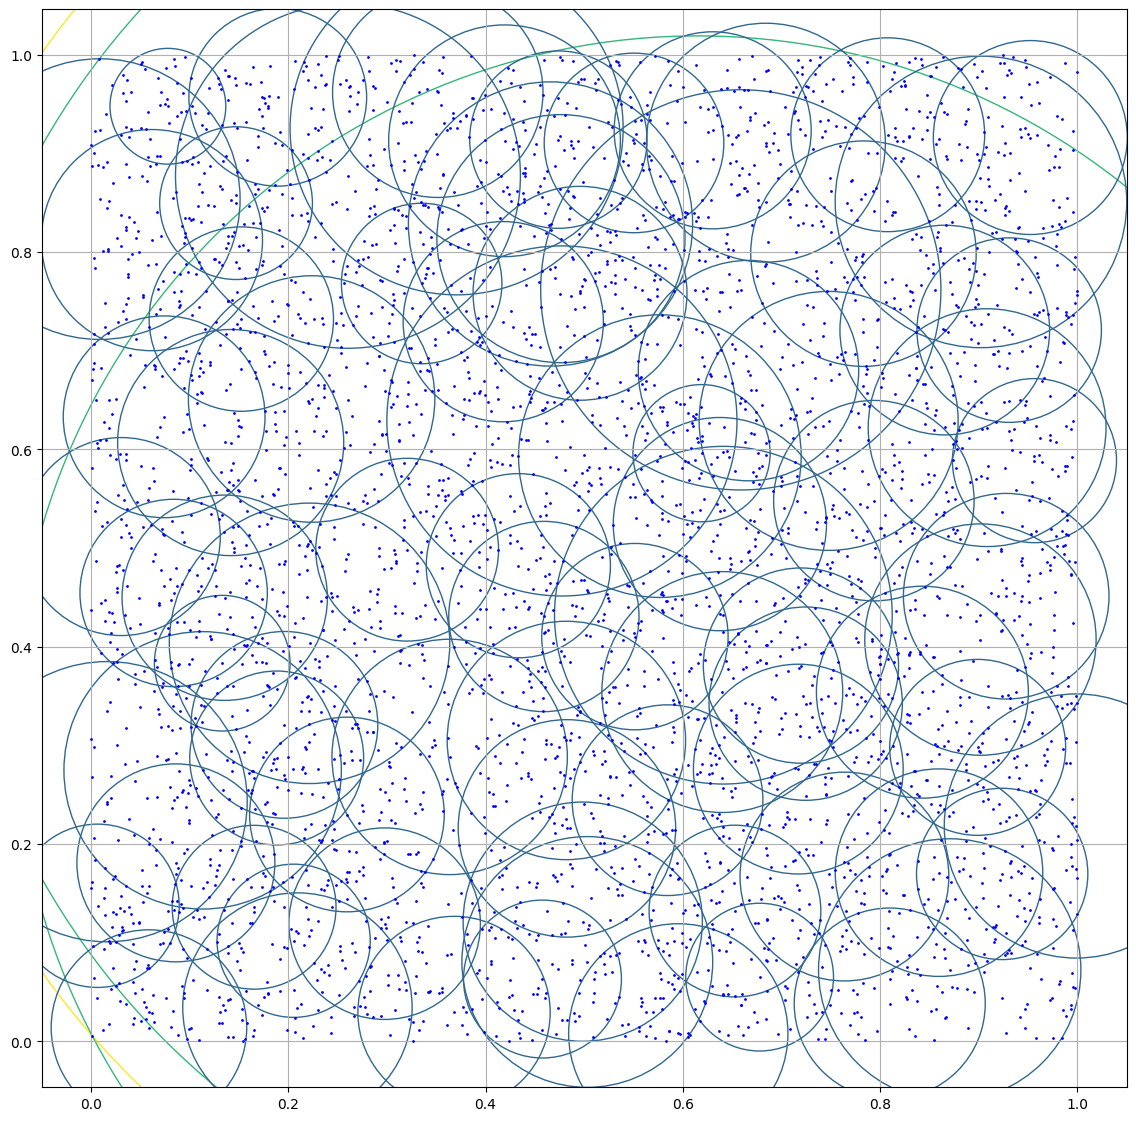

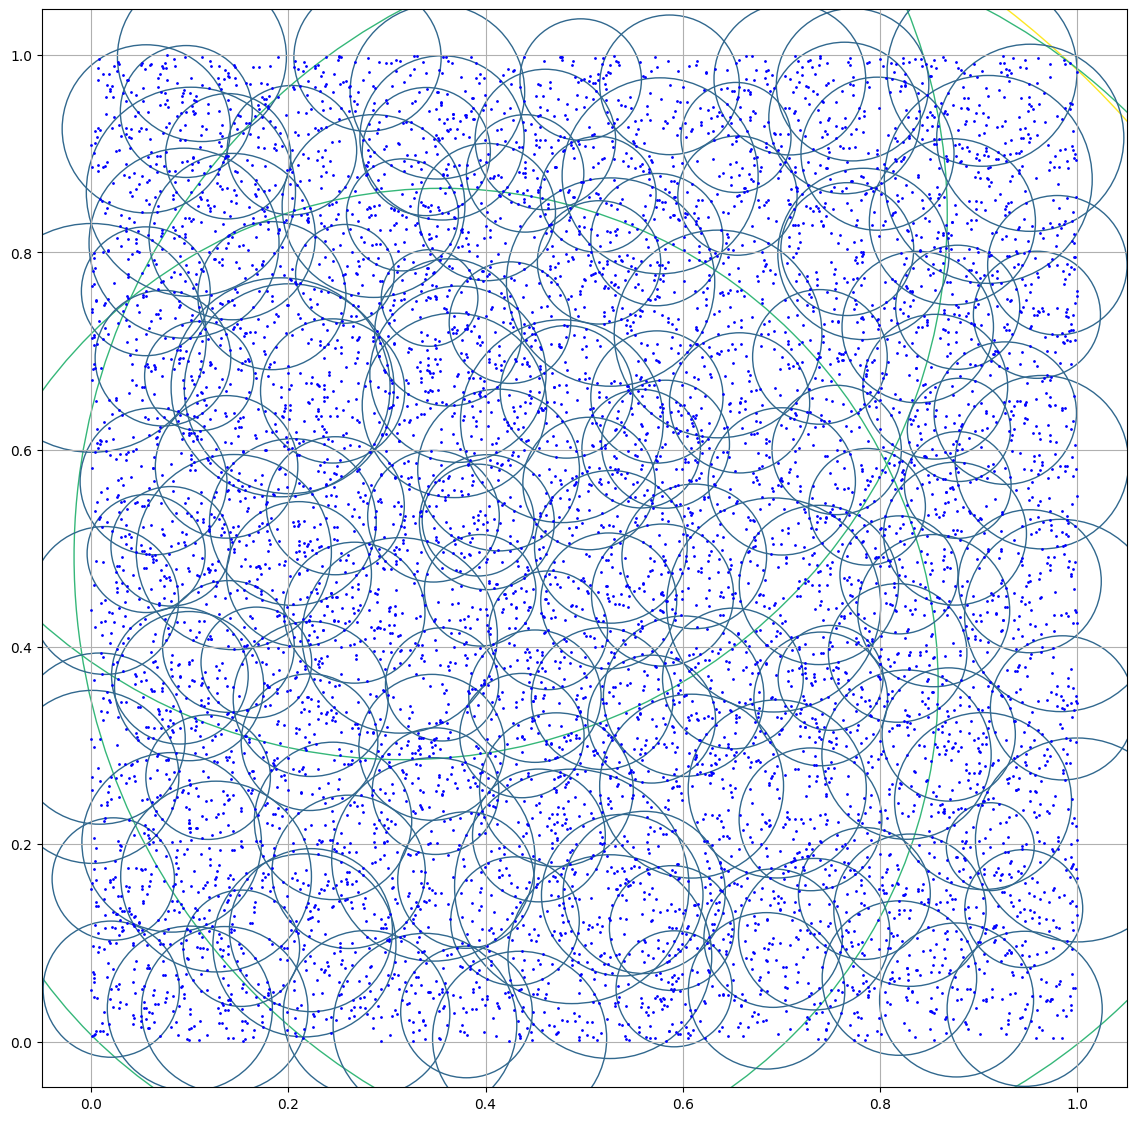

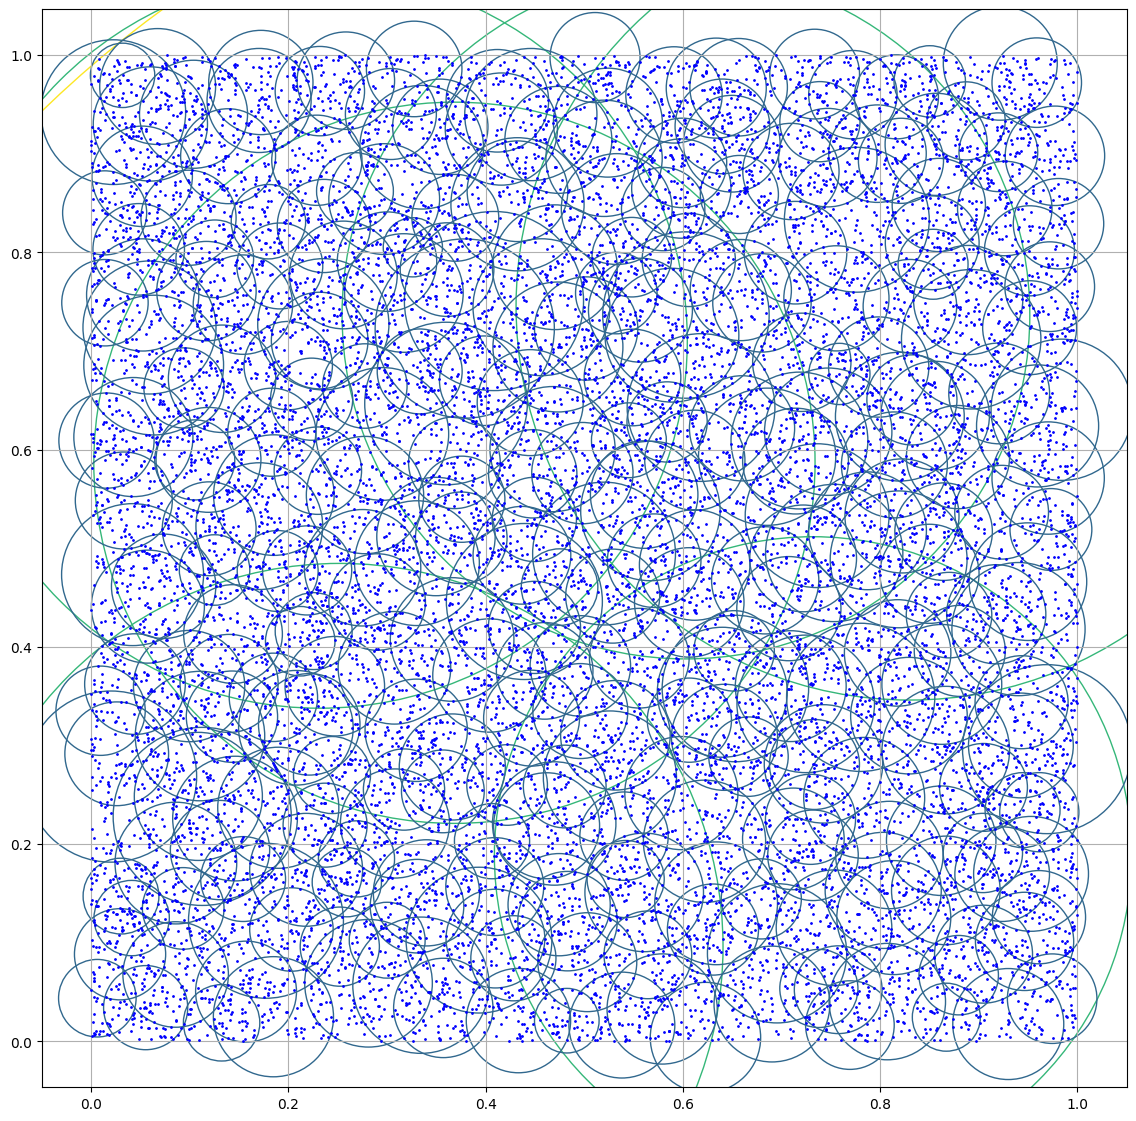

In [3]:
for size in [x+10 for x in range(6)]:
    graph_mtree(f"cp/mtree_{size}.csv")
